# Extract lineage information from Goo simulations, and plot the hierarchy

In [2]:
# general packages
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import os 
import json
import cv2
import re

# specific packages
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.lines import Line2D
from matplotlib.pyplot import xticks
from scipy.optimize import curve_fit
import matplotlib.ticker as tck
from sklearn.metrics import mean_squared_error
import matplotlib.lines as mlines
from sklearn.linear_model import LinearRegression
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties
from scipy.spatial.distance import euclidean
import networkx as nx

# set working directory
os.chdir("/Users/antoine/Harvard/MegasonLab/GPU_backup/AntoineRuzette/goo/data/division/")

font_props = {'family': 'Myriad Pro', 'size': 11}
font_props_text = {'family': 'Myriad Pro', 'size': 9}
title_font = FontProperties(family='Myriad Pro', size=11)


# colorblind-friendly colors
CB_palette = ['', '#f781bf', '#984ea3']

# set style
#sns.set_style("white")

In [41]:
# load data
with open(f"/Users/antoine/Harvard/MegasonLab/GPU_backup/AntoineRuzette/goo/data/division/20231218_division_2xtargetvolume-based_1-500/20231218_division_2xtargetvolume-based_volumes.json", 'r') as f1:
    volumes1 = json.load(f1)

In [43]:
def create_hierarchy(cell_names):
    hierarchy = {}

    for name in cell_names:
        parts = name.split('.')  # Split the cell name into parts
        current_level = hierarchy

        for part in parts:
            if part not in current_level:
                current_level[part] = {}  # Create a new level in the hierarchy
            current_level = current_level[part]  # Move to the next level

    return hierarchy


def complete_hierarchy(hierarchy, prefix=""):
    complete = {}
    for key, value in hierarchy.items():
        full_key = prefix + "." + key if prefix else key
        complete[full_key] = complete_hierarchy(value, full_key) if value else {}
    return complete

# Assuming volumes1 is a dictionary
cell_names = list(volumes1.keys())  # Converting keys to an array
print(f"Number of cells: {len(cell_names)}")

nested_hierarchy = create_hierarchy(cell_names)
complete_nested_hierarchy = complete_hierarchy(nested_hierarchy)
print(complete_nested_hierarchy)



{'cell_A1': {'cell_A1.002': {'cell_A1.002.002': {'cell_A1.002.002.002': {'cell_A1.002.002.002.002': {'cell_A1.002.002.002.002.002': {'cell_A1.002.002.002.002.002.002': {}, 'cell_A1.002.002.002.002.002.001': {}}, 'cell_A1.002.002.002.002.001': {'cell_A1.002.002.002.002.001.002': {}, 'cell_A1.002.002.002.002.001.001': {}}}, 'cell_A1.002.002.002.001': {'cell_A1.002.002.002.001.002': {'cell_A1.002.002.002.001.002.002': {}, 'cell_A1.002.002.002.001.002.001': {}}, 'cell_A1.002.002.002.001.001': {'cell_A1.002.002.002.001.001.002': {}, 'cell_A1.002.002.002.001.001.001': {}}}}, 'cell_A1.002.002.001': {'cell_A1.002.002.001.002': {'cell_A1.002.002.001.002.002': {'cell_A1.002.002.001.002.002.002': {}, 'cell_A1.002.002.001.002.002.001': {}}, 'cell_A1.002.002.001.002.001': {'cell_A1.002.002.001.002.001.002': {}, 'cell_A1.002.002.001.002.001.001': {}}}, 'cell_A1.002.002.001.001': {'cell_A1.002.002.001.001.002': {}, 'cell_A1.002.002.001.001.001': {}}}}, 'cell_A1.002.001': {'cell_A1.002.001.002': {'cel

Number of cells: 101


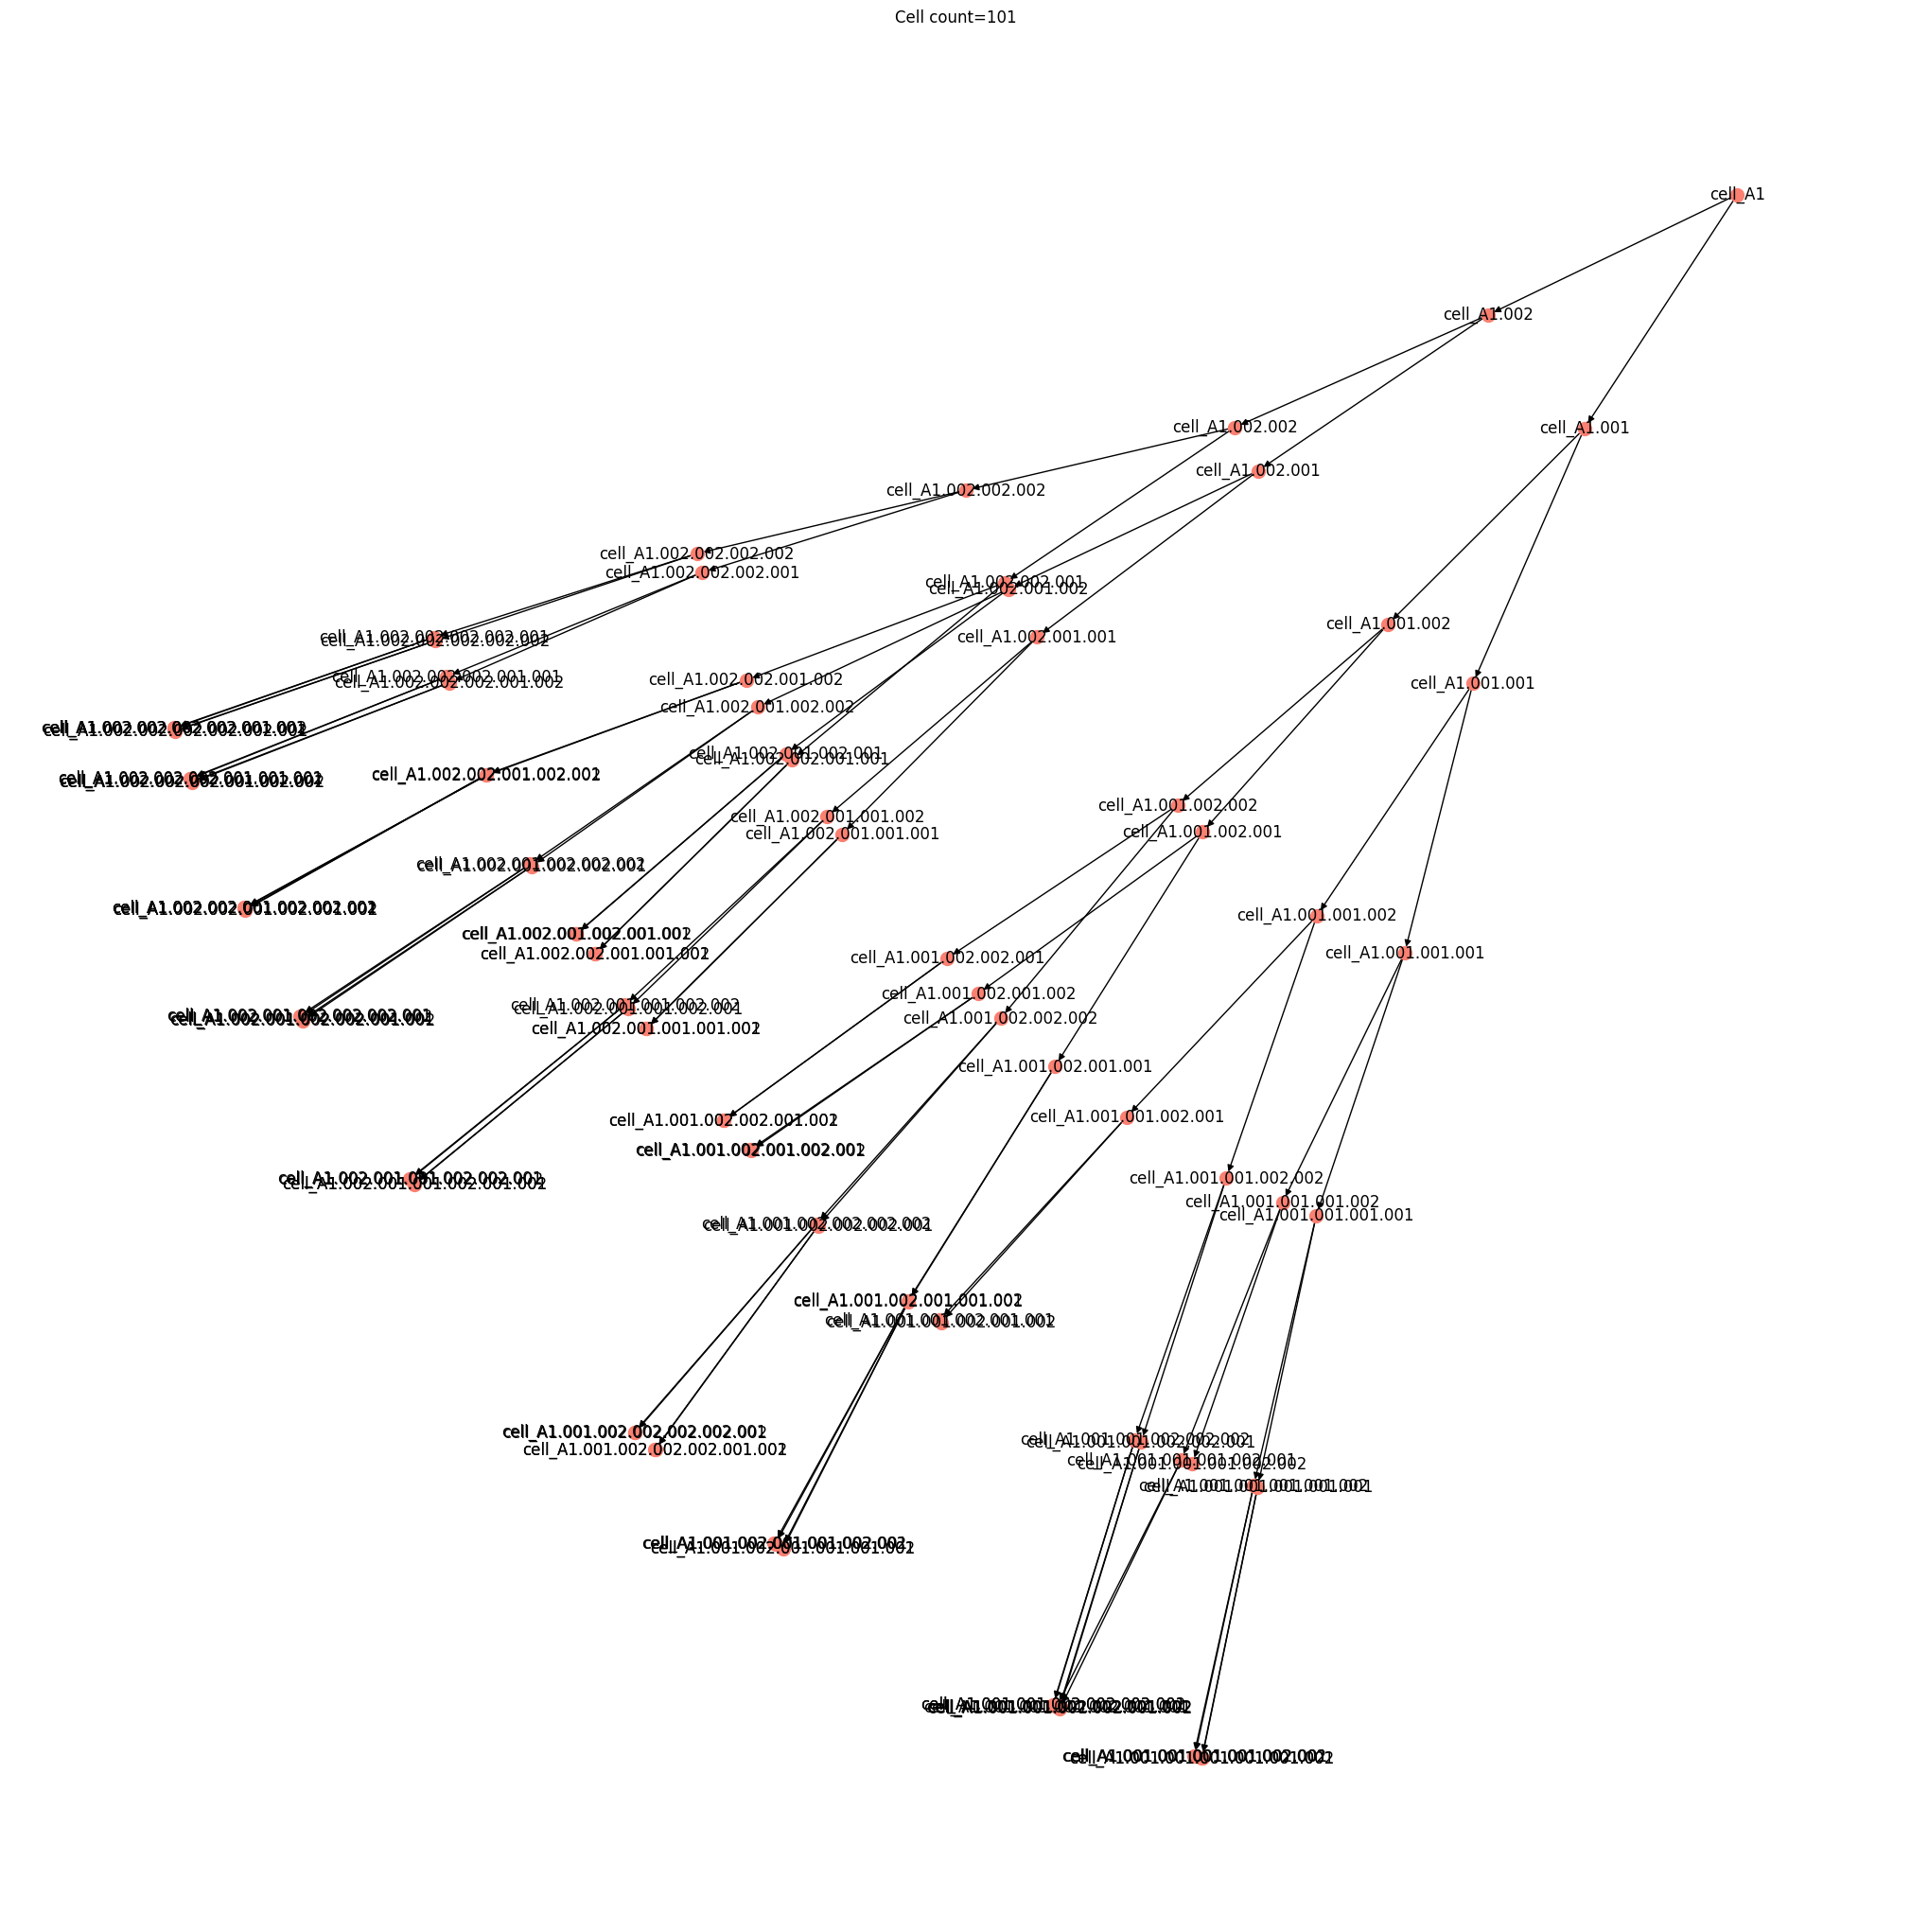

In [128]:
cell_names = list(volumes1.keys())  # Converting keys to an array
print(f"Number of cells: {len(cell_names)}")

def create_graph(hierarchy, parent=None):
    G = nx.DiGraph()
    for key, value in hierarchy.items():
        G.add_node(key)
        if parent:
            G.add_edge(parent, key)
        if isinstance(value, dict):
            G_sub = create_graph(value, key)
            G = nx.compose(G, G_sub)
    return G

# Create the graph from the hierarchy
G = create_graph(complete_nested_hierarchy)

# Plot the lineage tree with increased node spacing
plt.figure(figsize=(20, 20))
pos = nx.kamada_kawai_layout(G, dim=2)  # Adjusting the scale for increased spacing
nx.draw(G, pos, with_labels=True, node_size=100, node_color='salmon', font_size=12, arrows=True)
plt.title(f"Cell count={len(cell_names)}")
plt.savefig("division_lineage_kamada_kawai_layour.png", transparent=False, dpi=500)

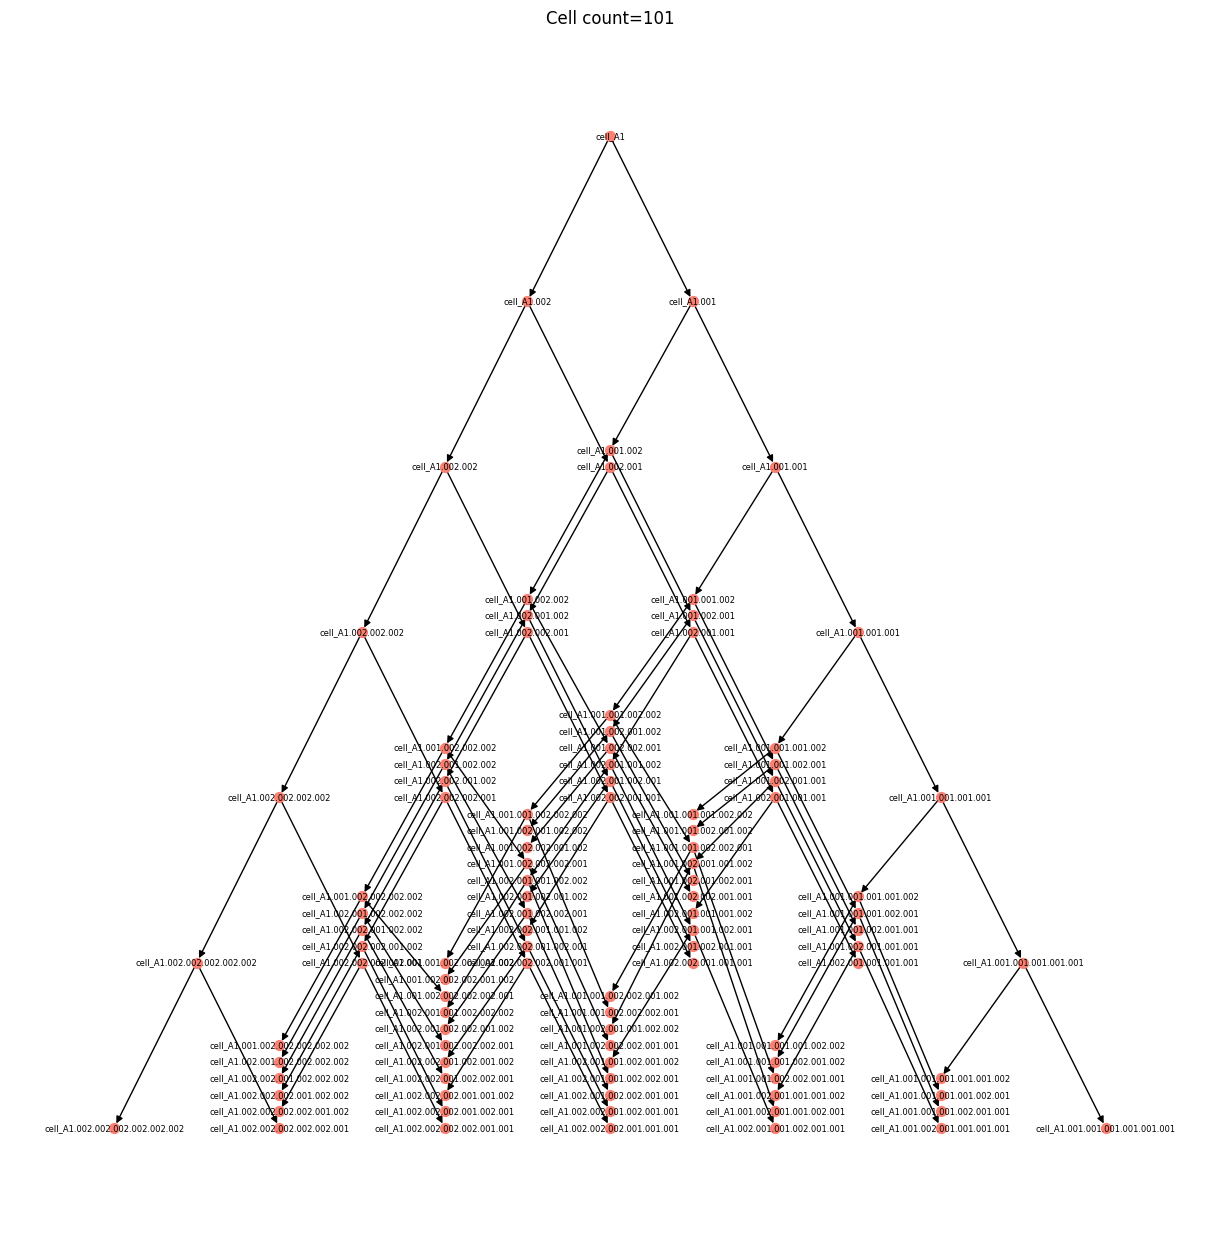

In [90]:
import networkx as nx
import matplotlib.pyplot as plt

def create_graph(hierarchy, parent=None):
    G = nx.DiGraph()
    for key, value in hierarchy.items():
        G.add_node(key)
        if parent:
            G.add_edge(parent, key)
        if isinstance(value, dict):
            G_sub = create_graph(value, key)
            G = nx.compose(G, G_sub)
    return G

# Create the graph from the hierarchy
G = create_graph(complete_nested_hierarchy)

# Calculate positions for nodes with adjusted height to avoid overlap
pos = {}
level_spacing = 100  # Adjust the spacing between levels
node_height = 10  # Adjust the node height to avoid overlap

def set_positions(node, level, x_offset, used_x):
    children = list(G.successors(node))
    num_children = len(children)
    if num_children > 0:
        x = x_offset - (num_children - 1) * level_spacing / 2
        for child in children:
            y = -level * level_spacing
            while (x, y) in used_x:  # Check if coordinates are already taken
                y += node_height
            pos[child] = (x, y)
            used_x.add((x, y))
            set_positions(child, level + 1, x, used_x)
            x += level_spacing

root_node = list(G.nodes())[0]  # Assuming the first node is the root
pos[root_node] = (0, 0)
set_positions(root_node, 1, 0, set())

# Plot the lineage tree with calculated node positions and adjusted height
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=50, node_color='salmon', font_size=6, arrows=True)
plt.title(f"Cell count={len(cell_names)}")
plt.savefig("division_lineage_hierarchical.png", transparent=False, dpi=500)

In [39]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Frame rate
fps = 24

# Example functions for creating hierarchy and completing it
# (These might be different based on your actual implementation)
def create_hierarchy(cell_names):
    hierarchy = {}
    for name in cell_names:
        parts = name.split('.')
        current_level = hierarchy
        for part in parts:
            if part not in current_level:
                current_level[part] = {}
            current_level = current_level[part]
    return hierarchy

def complete_hierarchy(hierarchy, prefix=""):
    complete = {}
    for key, value in hierarchy.items():
        full_key = prefix + "." + key if prefix else key
        complete[full_key] = complete_hierarchy(value, full_key) if value else {}
    return complete

# Generate hierarchy from cell names
cell_names = list(volumes1.keys())
hierarchy = complete_hierarchy(create_hierarchy(cell_names))

# Compute division times
division_times = {'cell_A1': 0}  # Assuming initial mother cell division at time 0
for cell_name, volumes in volumes1.items():
    if '.' in cell_name:
        mother_cell = cell_name.split('.')[0]
        if mother_cell in division_times:
            division_times[cell_name] = division_times[mother_cell] + len(volumes) / fps

# Plotting volumes over time with division time offsets
for cell_name, volumes in volumes1.items():
    offset = division_times.get(cell_name, 0)
    time_points = [(frame + 1) / fps + offset for frame in range(len(volumes))]
    plt.plot(time_points, volumes, label=cell_name)
    print(cell_name)

# Adding a horizontal line at y=4
plt.axhline(y=4.189, color='black', linestyle='--')
plt.text(0, 4.15, 'Initial mother volume: cell_A1', ha='left', va='top')

plt.xlabel('Time [seconds]; 24 fps')
plt.ylabel(r'Cellular volume $[\mu m^3]$')
#plt.legend(prop=FontProperties(family='Myriad Pro', size=9))

# Save the plot
plt.savefig("hierarchy_volumes_plot_with_offsets.png", transparent=False, dpi=500)
plt.show()


{'cell_A1': {'cell_A1.01': {'cell_A1.01.01': {'cell_A1.01.01.01': {'cell_A1.01.01.01.01': {}, 'cell_A1.01.01.01.02': {}}, 'cell_A1.01.01.02': {'cell_A1.01.01.02.01': {}, 'cell_A1.01.01.02.02': {}}}, 'cell_A1.01.02': {'cell_A1.01.02.01': {'cell_A1.01.02.01.01': {}, 'cell_A1.01.02.01.02': {}}, 'cell_A1.01.02.02': {'cell_A1.01.02.02.01': {}, 'cell_A1.01.02.02.02': {}}}}, 'cell_A1.02': {'cell_A1.02.01': {'cell_A1.02.01.01': {'cell_A1.02.01.01.01': {}, 'cell_A1.02.01.01.02': {}}, 'cell_A1.02.01.02': {'cell_A1.02.01.02.01': {}, 'cell_A1.02.01.02.02': {}}}, 'cell_A1.02.02': {'cell_A1.02.02.01': {'cell_A1.02.02.01.01': {}, 'cell_A1.02.02.01.02': {}}, 'cell_A1.02.02.02': {'cell_A1.02.02.02.01': {}, 'cell_A1.02.02.02.02': {}}}}}}


NameError: name 'volumes1' is not defined

In [26]:
# load data
with open(f"/Users/antoine/Harvard/MegasonLab/GPU_backup/AntoineRuzette/goo/data/division/20240102_division_tests/test03_volumes.json", 'r') as f1:
    volumes_data = json.load(f1)
with open(f"/Users/antoine/Harvard/MegasonLab/GPU_backup/AntoineRuzette/goo/data/division/20240102_division_tests/test03_frame_cells.json", 'r') as f1:
    frame_data = json.load(f1)
with open(f"/Users/antoine/Harvard/MegasonLab/GPU_backup/AntoineRuzette/goo/data/division/20240102_division_tests/test03_times.json", 'r') as f1:
    times_data = json.load(f1)

1


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_88303/3292542462.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([f'{value:.0f}' for value in values])  # Set labels using the corresponding values


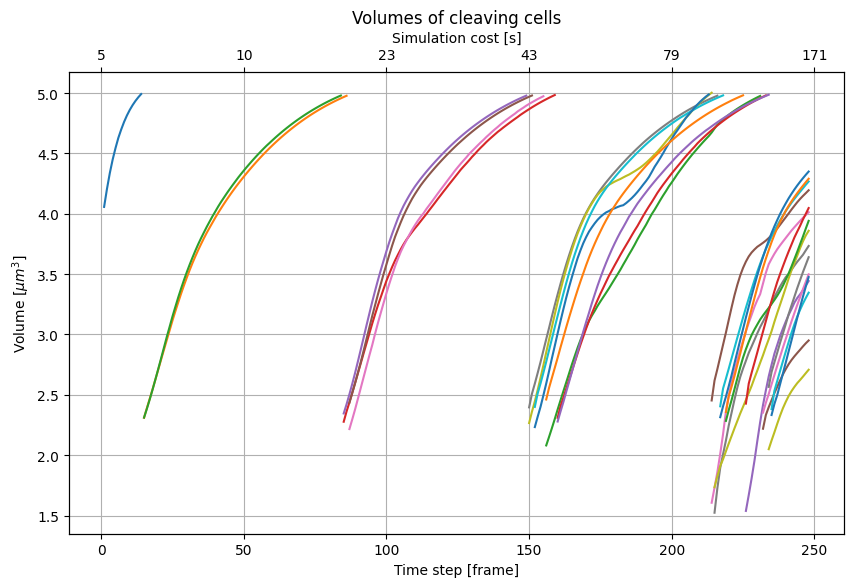

In [36]:
import matplotlib.pyplot as plt

# FPS (frames per second)
fps = 24

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twiny()  # Create a secondary x-axis

count = 0
for cell_name, volumes in volumes_data.items():
    frames = frame_data[cell_name]
    # Truncate frames if longer than volumes
    if len(frames) > len(volumes):
        frames = frames[:len(volumes)]
        count += 1

    ax1.plot(frames, volumes, label=cell_name)

print(count)

# Plotting the secondary x-axis with the converted numerical data at regular intervals
keys = list(times_data.keys())[::41]  # Select keys at regular intervals
values = [times_data[key] for key in keys]  # Corresponding values

ax2.set_xlim(ax1.get_xlim())  # Set limits to match the primary x-axis
#ax2.set_xticks(map(int, keys))  # Set the ticks using the selected keys
ax2.set_xticklabels([f'{value:.0f}' for value in values])  # Set labels using the corresponding values


ax2.set_xlabel('simulation cost [s]')

# Convert frame numbers to time in seconds
# times = [sim_time for sim_time in frame_data]
# ax2.plot(times, alpha=0)  # Plotting on the secondary x-axis

ax1.set_xlabel('Time step [frame]')
ax1.set_ylabel(r'Volume [$\mu m^3$]')
ax2.set_xlabel(r'Simulation cost [s]')

ax1.set_title('Volumes of cleaving cells')
# ax1.legend()  # Legend for the primary x-axis plot
ax1.grid(True)

# Saving the plot
plt.savefig("volumes_frame_time.png", transparent=False, dpi=500)

plt.show()

In [50]:
def create_hierarchy(cell_names):
    hierarchy = {}

    for name in cell_names:
        parts = name.split('.')  # Split the cell name into parts
        current_level = hierarchy

        for part in parts:
            if part not in current_level:
                current_level[part] = {}  # Create a new level in the hierarchy
            current_level = current_level[part]  # Move to the next level

    return hierarchy


def complete_hierarchy(hierarchy, prefix=""):
    complete = {}
    for key, value in hierarchy.items():
        full_key = prefix + "." + key if prefix else key
        complete[full_key] = complete_hierarchy(value, full_key) if value else {}
    return complete

# Assuming volumes1 is a dictionary
cell_names = list(volumes_data.keys())  # Converting keys to an array
print(f"Number of cells: {len(cell_names)}")

nested_hierarchy = create_hierarchy(cell_names)
complete_nested_hierarchy = complete_hierarchy(nested_hierarchy)
print(complete_nested_hierarchy)



Number of cells: 31
{'cell_A1': {'cell_A1.01': {'cell_A1.01.01': {'cell_A1.01.01.01': {'cell_A1.01.01.01.01': {}, 'cell_A1.01.01.01.02': {}}, 'cell_A1.01.01.02': {'cell_A1.01.01.02.01': {}, 'cell_A1.01.01.02.02': {}}}, 'cell_A1.01.02': {'cell_A1.01.02.01': {'cell_A1.01.02.01.01': {}, 'cell_A1.01.02.01.02': {}}, 'cell_A1.01.02.02': {'cell_A1.01.02.02.01': {}, 'cell_A1.01.02.02.02': {}}}}, 'cell_A1.02': {'cell_A1.02.01': {'cell_A1.02.01.01': {'cell_A1.02.01.01.01': {}, 'cell_A1.02.01.01.02': {}}, 'cell_A1.02.01.02': {'cell_A1.02.01.02.01': {}, 'cell_A1.02.01.02.02': {}}}, 'cell_A1.02.02': {'cell_A1.02.02.01': {'cell_A1.02.02.01.01': {}, 'cell_A1.02.02.01.02': {}}, 'cell_A1.02.02.02': {'cell_A1.02.02.02.01': {}, 'cell_A1.02.02.02.02': {}}}}}}


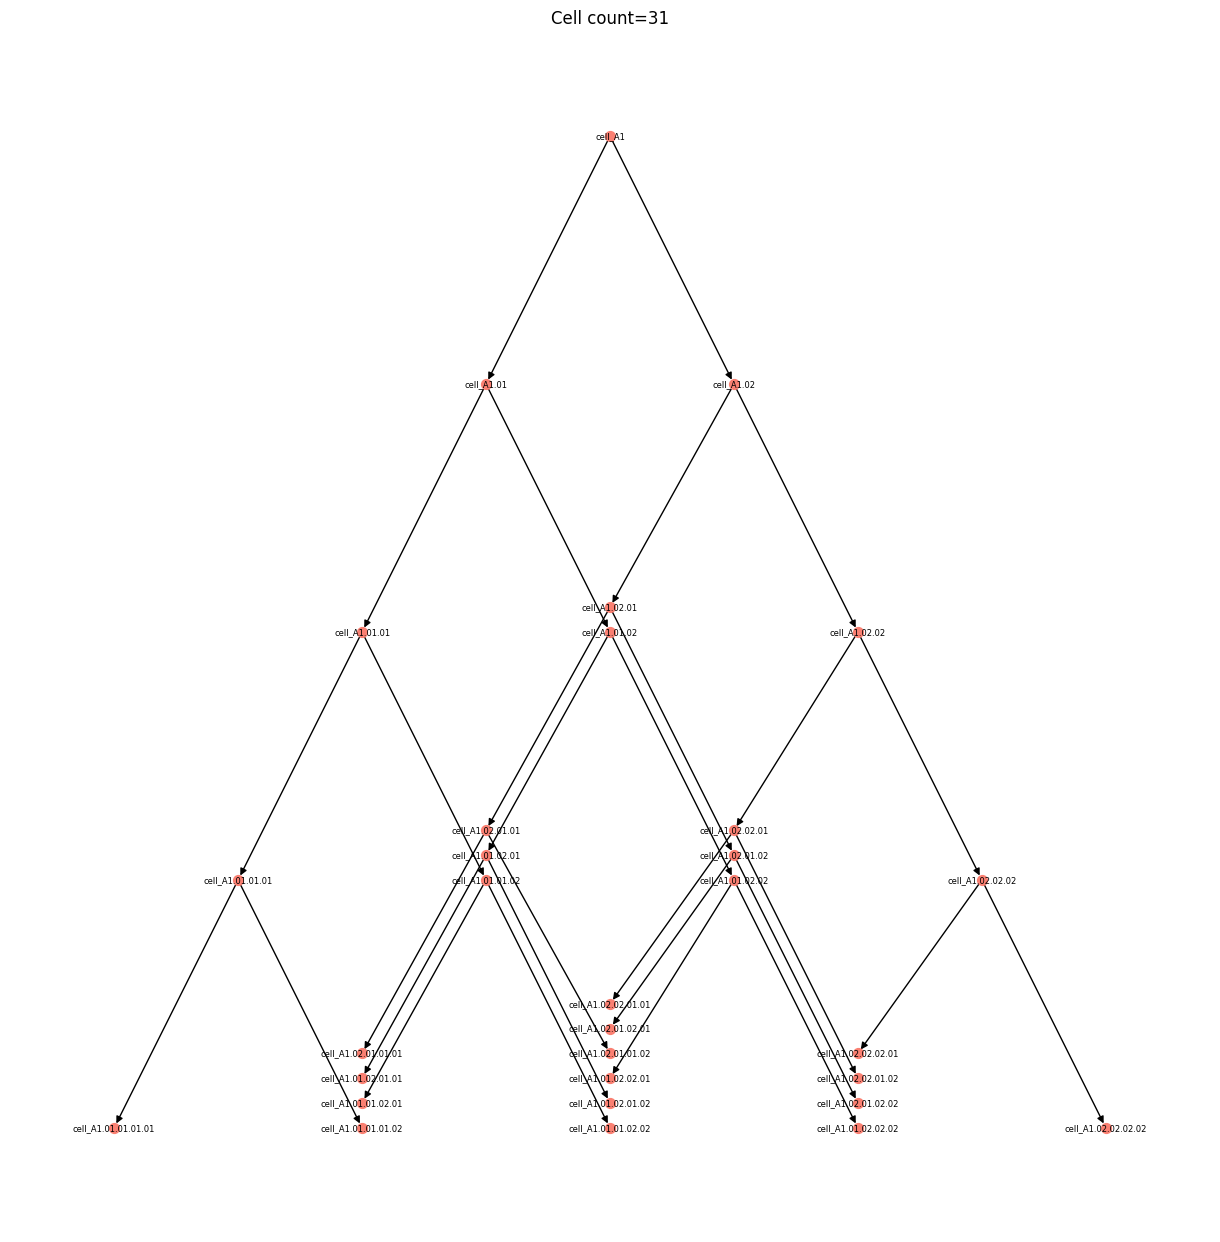

In [48]:
def create_graph(hierarchy, parent=None):
    G = nx.DiGraph()
    for key, value in hierarchy.items():
        G.add_node(key)
        if parent:
            G.add_edge(parent, key)
        if isinstance(value, dict):
            G_sub = create_graph(value, key)
            G = nx.compose(G, G_sub)
    return G

# Create the graph from the hierarchy
G = create_graph(complete_nested_hierarchy)

# Calculate positions for nodes with adjusted height to avoid overlap
pos = {}
level_spacing = 100  # Adjust the spacing between levels
node_height = 10  # Adjust the node height to avoid overlap

def set_positions(node, level, x_offset, used_x):
    children = list(G.successors(node))
    num_children = len(children)
    if num_children > 0:
        x = x_offset - (num_children - 1) * level_spacing / 2
        for child in children:
            y = -level * level_spacing
            while (x, y) in used_x:  # Check if coordinates are already taken
                y += node_height
            pos[child] = (x, y)
            used_x.add((x, y))
            set_positions(child, level + 1, x, used_x)
            x += level_spacing

root_node = list(G.nodes())[0]  # Assuming the first node is the root
pos[root_node] = (0, 0)
set_positions(root_node, 1, 0, set())

# Plot the lineage tree with calculated node positions and adjusted height
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=50, node_color='salmon', font_size=6, arrows=True)
plt.title(f"Cell count={len(cell_names)}")
plt.savefig("division_lineage_hierarchical.png", transparent=False, dpi=500)

Number of cells: 121
{'cell_A1': {'cell_A1.01': {'cell_A1.01.01': {'cell_A1.01.01.01': {'cell_A1.01.01.01.01': {'cell_A1.01.01.01.01.01': {'cell_A1.01.01.01.01.01.01': {}, 'cell_A1.01.01.01.01.01.02': {}}, 'cell_A1.01.01.01.01.02': {'cell_A1.01.01.01.01.02.01': {'cell_A1.01.01.01.01.02.01.01': {}, 'cell_A1.01.01.01.01.02.01.02': {}}, 'cell_A1.01.01.01.01.02.02': {'cell_A1.01.01.01.01.02.02.01': {}, 'cell_A1.01.01.01.01.02.02.02': {}}}}, 'cell_A1.01.01.01.02': {'cell_A1.01.01.01.02.01': {'cell_A1.01.01.01.02.01.01': {}, 'cell_A1.01.01.01.02.01.02': {}}, 'cell_A1.01.01.01.02.02': {'cell_A1.01.01.01.02.02.01': {}, 'cell_A1.01.01.01.02.02.02': {}}}}, 'cell_A1.01.01.02': {'cell_A1.01.01.02.01': {'cell_A1.01.01.02.01.01': {'cell_A1.01.01.02.01.01.01': {}, 'cell_A1.01.01.02.01.01.02': {}}, 'cell_A1.01.01.02.01.02': {'cell_A1.01.01.02.01.02.01': {}, 'cell_A1.01.01.02.01.02.02': {}}}, 'cell_A1.01.01.02.02': {'cell_A1.01.01.02.02.01': {'cell_A1.01.01.02.02.01.01': {}, 'cell_A1.01.01.02.02.01.02'

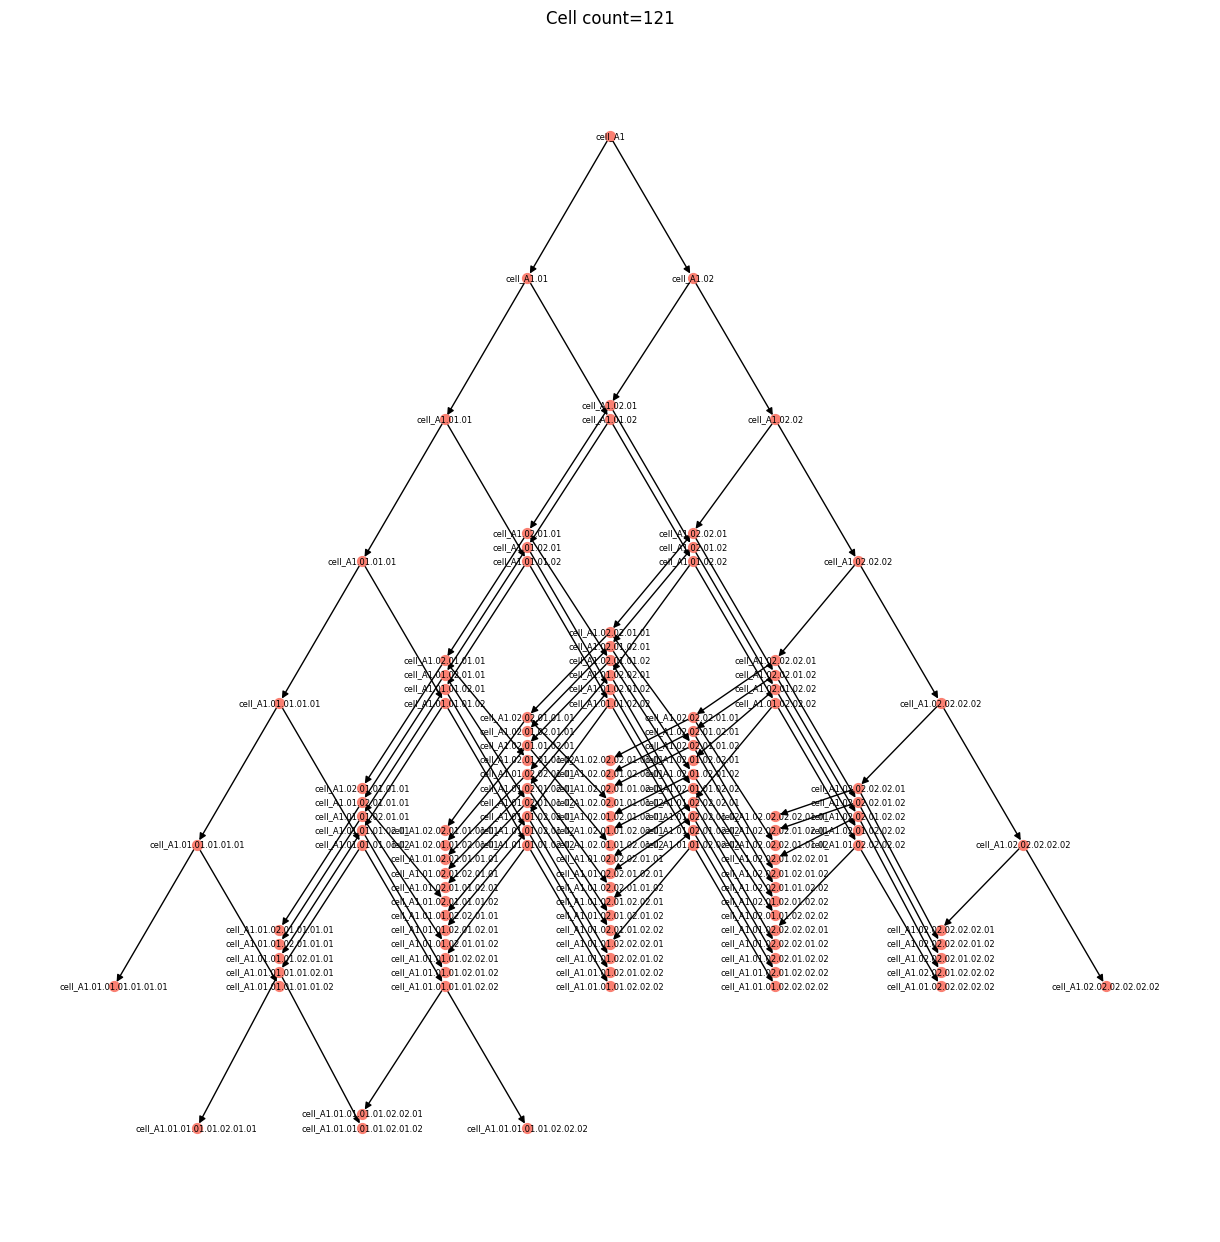

In [8]:
with open(f"/Users/antoine/Harvard/MegasonLab/GPU_backup/AntoineRuzette/goo/data/division/20240227_division_targetvolume30/20240227_division_frame150_targetvolume30_volumes.json", 'r') as f1:
    volumes1 = json.load(f1)

def create_hierarchy(cell_names):
    hierarchy = {}

    for name in cell_names:
        parts = name.split('.')  # Split the cell name into parts
        current_level = hierarchy

        for part in parts:
            if part not in current_level:
                current_level[part] = {}  # Create a new level in the hierarchy
            current_level = current_level[part]  # Move to the next level

    return hierarchy


def complete_hierarchy(hierarchy, prefix=""):
    complete = {}
    for key, value in hierarchy.items():
        full_key = prefix + "." + key if prefix else key
        complete[full_key] = complete_hierarchy(value, full_key) if value else {}
    return complete

# Assuming volumes1 is a dictionary
cell_names = list(volumes1.keys())  # Converting keys to an array
print(f"Number of cells: {len(cell_names)}")

nested_hierarchy = create_hierarchy(cell_names)
complete_nested_hierarchy = complete_hierarchy(nested_hierarchy)
print(complete_nested_hierarchy)

import networkx as nx
import matplotlib.pyplot as plt

def create_graph(hierarchy, parent=None):
    G = nx.DiGraph()
    for key, value in hierarchy.items():
        G.add_node(key)
        if parent:
            G.add_edge(parent, key)
        if isinstance(value, dict):
            G_sub = create_graph(value, key)
            G = nx.compose(G, G_sub)
    return G

# Create the graph from the hierarchy
G = create_graph(complete_nested_hierarchy)

# Calculate positions for nodes with adjusted height to avoid overlap
pos = {}
level_spacing = 100  # Adjust the spacing between levels
node_height = 10  # Adjust the node height to avoid overlap

def set_positions(node, level, x_offset, used_x):
    children = list(G.successors(node))
    num_children = len(children)
    if num_children > 0:
        x = x_offset - (num_children - 1) * level_spacing / 2
        for child in children:
            y = -level * level_spacing
            while (x, y) in used_x:  # Check if coordinates are already taken
                y += node_height
            pos[child] = (x, y)
            used_x.add((x, y))
            set_positions(child, level + 1, x, used_x)
            x += level_spacing

root_node = list(G.nodes())[0]  # Assuming the first node is the root
pos[root_node] = (0, 0)
set_positions(root_node, 1, 0, set())

# Plot the lineage tree with calculated node positions and adjusted height
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=50, node_color='salmon', font_size=6, arrows=True)
plt.title(f"Cell count={len(cell_names)}")
plt.savefig("/Users/antoine/Harvard/MegasonLab/GPU_backup/AntoineRuzette/goo/data/division/20240227_division_targetvolume30/division_lineage_hierarchical.png", transparent=False, dpi=500)
